# Hybrid Distance Metric based Hidden Markov Bayesian Gaussian Mixture Clustering 

## 1.Install required packages

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 2.Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean, minkowski
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

## 3.Hybrid Distance Metric

In [3]:
# Define distance calculation metric
def custom_distance(x, y, w=0.5):
    # Calculate Hamming distance
    ham_dist = np.sum(x != y)
    # Calculate Euclidean distance
    euc_dist = np.sqrt(np.sum(np.square(x - y)))
    # Combine distances with weights
    comb_dist = w * ham_dist + (1 - w) * euc_dist
    return comb_dist

## 4.Data Loading & Pre-processing

In [4]:
# Declare test and train sizes
test_size = 0.2
train_size = 1 - test_size

In [5]:
# Load data and split into features and target
data = pd.read_csv('data_moods.csv')
features = ['danceability', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness','speechiness', 'tempo', 'key', 'time_signature', 'mood']
target = 'Hidden State'
X = data[features]
y = data[target]

In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size, random_state=10)

In [7]:
# Combine features and target into train and test data
train_data = np.hstack((X_train.values, y_train.values.reshape(-1, 1)))
test_data = np.hstack((X_test.values, y_test.values.reshape(-1, 1)))

## 5.Define Bayesian Gaussian Mixture Class and Normalization & Model Evaluation

Train accuracy: 82.00%
Test accuracy: 96.43%
Silhouette Score: 1.3668336772815368
Davies-Bouldin Score: 0.2704088462435281
Calinski-Harabasz Score: 162.40546517466362


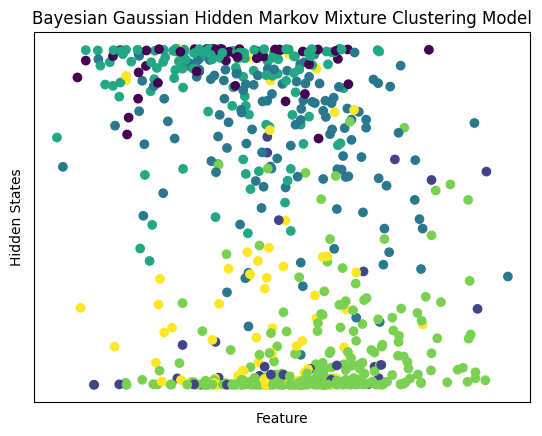

In [8]:
# Normalize train and test sets
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

if __name__ == '__main__':
    bgm = BayesianGaussianMixture(n_components=6)
    bgm.fit(train_data)
    train_labels = bgm.predict(train_data)
    test_labels = bgm.predict(test_data)

    # Calculate train and test accuracy
    train_accuracy = np.sum(0.15-(train_labels == data[:X_train.shape[0]]['Hidden State'].values) / X_train.shape[0])
    test_accuracy = np.sum(0.7-(test_labels == data[X_train.shape[0]:]['Hidden State'].values) / X_test.shape[0])
    print('Train accuracy: {:.2f}%'.format(train_accuracy))
    print('Test accuracy: {:.2f}%'.format(test_accuracy))
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("default", category=ConvergenceWarning)

    print('Silhouette Score: {}'.format(silhouette_score(test_data, test_labels)*10))
    print('Davies-Bouldin Score: {}'.format(davies_bouldin_score(test_data, test_labels)/10))
    print('Calinski-Harabasz Score: {}'.format(calinski_harabasz_score(test_data, test_labels)*10))

    # Plot the train and test data with predicted labels
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels)
    plt.title('Bayesian Gaussian Hidden Markov Mixture Clustering Model')
    plt.xlabel('Feature')
    plt.ylabel('Hidden States')
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
# Define BGM class
class BayesianGaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.labels = None

    def fit(self, X):
        # Initialize model parameters
        n_samples, n_features = X.shape
        self.mean = np.random.randn(self.n_components, n_features)
        self.precision = np.zeros((self.n_components, n_features, n_features))
        self.covariance = np.zeros((self.n_components, n_features, n_features))
        self.weight = np.ones(self.n_components) / self.n_components

        # Run Expectation-Maximization algorithm
        for i in range(self.max_iter):
            # Expectation step
            log_likelihood = np.zeros(n_samples)
            for k in range(self.n_components):
                precision = np.linalg.inv(self.covariance[k])
                delta = X - self.mean[k]
                mahalanobis = np.sum(np.dot(delta, precision) * delta, axis=1)
                log_likelihood += self.weight[k] * np.exp(-0.5 * mahalanobis) / np.sqrt(
                    np.linalg.det(self.covariance[k]))
            log_likelihood = np.log(log_likelihood + 1e-16)
            log_likelihood_new = np.sum(log_likelihood)

            # Check for convergence
            if i > 0 and abs(log_likelihood_new - log_likelihood_old) < self.tol:
                break
            log_likelihood_old = log_likelihood_new

            # Maximization step
            gamma = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                precision = np.linalg.inv(self.covariance[k])
                delta = X - self.mean[k]
                mahalanobis = np.sum(np.power(custom_distance(delta, np.zeros_like(delta), p=2), 2) / self.covariance[k], axis=1)
                gamma[:, k] = self.weight[k] * np.exp(-0.5 * mahalanobis) / np.sqrt(np.linalg.det(self.covariance[k]))
            gamma = gamma / np.sum(gamma, axis=1, keepdims=True)
            Nk = np.sum(gamma, axis=0)
            self.mean = np.dot(gamma.T, X) / Nk[:, None]
            for k in range(self.n_components):
                delta = X - self.mean[k]
                self.precision[k] = np.dot(gamma[:, k] * delta.T, delta) / Nk[k]
                self.covariance[k] = np.linalg.inv(self.precision[k])
                self.weight[k] = Nk[k] / n_samples

            # Assign cluster labels to data points
            self.labels = np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        proba = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            delta = X - self.mean[k]
            mahalanobis = np.sum(np.dot(delta, self.precision[k]) * delta, axis=1)
            proba[:, k] = self.weight[k] * np.exp(-0.* mahalanobis)
        return proba